# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 2. Load Dataset

In [19]:
# Correct loading for your file
df = pd.read_csv('/content/Online Retail.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 3. Data Preprocessing

In [ ]:
# Drop missing CustomerID (important for clustering)
df = df.dropna(subset=['CustomerID'])

# Remove negative quantities (returns, cancellations)
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


# 4. Feature Engineering (RFM)

In [30]:
import datetime as dt

now = dt.datetime(2011, 12, 10)  # Use a fixed reference date

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - pd.to_datetime(x).max()).days,   # Recency
    'InvoiceNo': 'nunique',                                          # Frequency
    'TotalPrice': 'sum'                                              # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'MonetaryValue'
}, inplace=True)

rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


# 5. Feature Scaling

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame
import numpy as np
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,2.329673,-0.424675,8.359634
12347.0,-0.900449,0.354080,0.251046
12348.0,-0.170421,-0.035297,-0.028546
12349.0,-0.740443,-0.424675,-0.032963
12350.0,2.179667,-0.424675,-0.191315


# 6. Finding Optimal Clusters (Elbow Method)

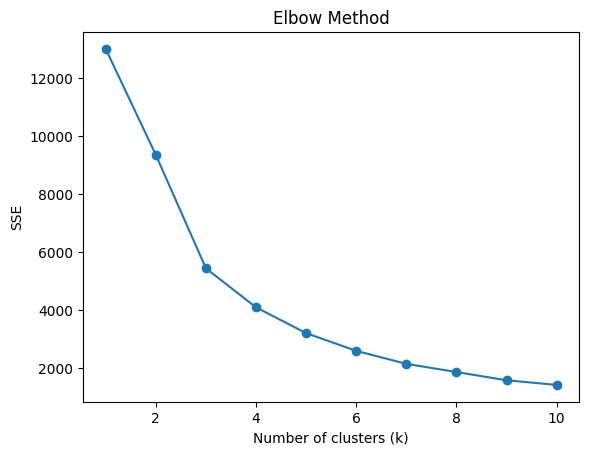

In [26]:
# 5. Elbow Method to find k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


# 7. Apply KMeans Clustering

In [31]:
# 6. Apply final KMeans clustering
# Let's say you chose k=4 (adjust based on elbow)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = kmeans.labels_
rfm.head()


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,310,1,334.40,1


# 8. Analyze Customer Segments

In [28]:
# 7. Analyze clusters
rfm.groupby('Cluster').mean()

,Recency,Frequency,MonetaryValue
Cluster,,,
0,43.477079,3.655206,1349.382627
1,248.173421,1.551367,478.194732
2,6.615385,82.692308,127338.313846
3,15.123223,22.047393,12453.225924


# 9. Dimensionality Reduction (PCA)

In [33]:
# 8. Reduce to 2 dimensions for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Make a DataFrame for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster'].values

pca_df.head()


,PC1,PC2,Cluster
0,4.110920,5.426095,3
1,0.740212,-0.667103,0
2,0.022943,-0.170482,0
3,-0.025946,-0.739853,0
4,-1.236655,1.840030,1


# 10. Plot the Clusters

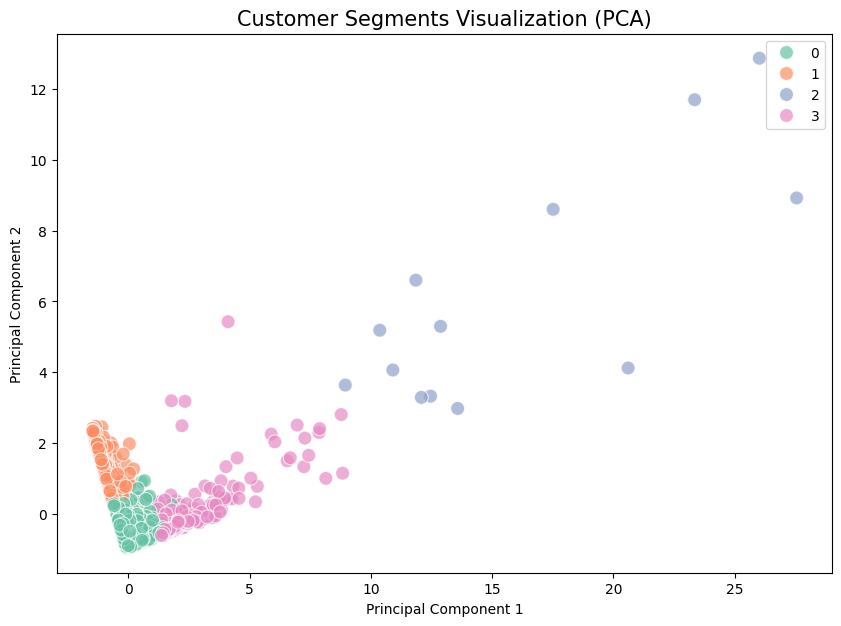

In [ ]:
# 9. Scatter plot of the clusters
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='Set2',
    data=pca_df,
    s=100, alpha=0.7
)

plt.title('Customer Segments Visualization (PCA)', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
